In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg

In [2]:
def binning(x,y,nbin=10,eq = True):
    step = (np.max(x)-np.min(x))/(nbin)
    X = []
    Y = []
    Yerr = []
    tmpY = []
    start = np.min(x)+step
    if eq:
        for i in range(len(x)):
            while x[i] > start:
                X.append(start-step/2)
                Y.append(np.mean(tmpY))
                #Xerr.append(np.std(tmpX,ddof=1) /np.sqrt(len(tmpX)) )
                Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
                start += step
                tmpY=[]
                pass
            tmpY.append(y[i])
            pass
        if len(tmpY)!=0:
            X.append(start-step/2)
            Y.append(np.mean(tmpY))
            Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
        return X,Y,Yerr
        pass
    else:
        tmpX = []
        Xerr = []
        for i in range(len(x)):
            while x[i] > start:
                X.append(np.mean(tmpX))
                Y.append(np.mean(tmpY))
                Xerr.append(np.std(tmpX,ddof=1) /np.sqrt(len(tmpX)) )
                Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
                start += step
                tmpX=[]
                tmpY=[]
                pass
            tmpX.append(x[i])
            tmpY.append(y[i])
            pass
        if len(tmpY)!=0:
            X.append(np.mean(tmpX))
            Y.append(np.mean(tmpY))
            Xerr.append(np.std(tmpX,ddof=1) /np.sqrt(len(tmpX)) )
            Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
        return X, Y, Yerr

In [3]:
def PreProcessing(t,price):
    T = np.zeros(len(t))
    Price = np.zeros(len(t))
    prev = t[0]
    n = 0
    for i in range(len(t)):
        n += (prev != t[i])
        T[n] = t[i]
        Price[n] = price[i]
        prev = t[i]
        pass
    return T[:n+1],Price[:n+1]

In [4]:
INTC_LOB   = np.sort(["../../Data/INTC/"+i for i in os.listdir("../../Data/INTC") if i[-8]=="k"])
TSLA_LOB   = np.sort(["../../Data/TSLA/"+i for i in os.listdir("../../Data/TSLA") if i[-8]=="k"])
INTC_order = np.sort(["../../Data/INTC/"+i for i in os.listdir("../../Data/INTC") if i[-8]!="k"])
TSLA_order = np.sort(["../../Data/TSLA/"+i for i in os.listdir("../../Data/TSLA") if i[-8]!="k"])

## 2.2 Price flactuation and diffusion
``Here, the price $p_n$ is defined as the mid-point before n-th trade: $p_n:=m_{m^{-}}$''

In [5]:
def GetPriceBeforeTransaction(time, record, midprice):
    Mid = np.zeros(time.shape[0])
    prev = time[0]
    n = 0
    Mid[n] = prev
    for i,z,w in zip(midprice,record,time):
        n +=  ((z==4 or z==5) and prev != w)
        Mid[n] = i
        prev = w
        pass
    return Mid[:n]
    pass


In [9]:
TSLAPrice = []
for i,z in zip(TSLA_order,TSLA_LOB):
    data = pd.read_csv(i,header=None)[[0,1]]
    lob = pd.read_csv(z,header=None)[[0,2]]
    data[2] = (lob[0]+lob[2])/2
    a=GetPriceBeforeTransaction(data[0].values,data[1].values, data[2].values)
    TSLAPrice.extend(a.tolist().copy())
    pass
TSLAPrice = np.array(TSLAPrice)/10000


## Response function and market impact
Response function of transaction can be defined as
$$
R(l) := \left\langle \left( p(l+t) -p(t)\right)\epsilon(t) \right\rangle
$$

In [10]:
def ResponseFunction(time, record, midprice, sign):
    Mid = np.zeros(time.shape[0])
    Sign = np.zeros(time.shape[0])
    prev = 0
    n = 0
    Mid[n] = midprice[n]
    for i,z,w,s in zip(midprice,record,time,sign):
        Sign[n] += s*((z==4 or z==5) and prev != w)
        n +=  ((z==4 or z==5) and prev != w)
        Mid[n] = i
        prev = w
        pass
    return Mid[:n],-Sign[:n]
    pass

In [11]:
TSLAPrice = []
TSLASign = []
for i,z in zip(TSLA_order,TSLA_LOB):
    data = pd.read_csv(i,header=None)[[0,1,5]]
    lob = pd.read_csv(z,header=None)[[0,2]]
    data[2] = (lob[0]+lob[2])/2
    a,b=ResponseFunction(data[0].values,data[1].values, data[2].values,data[5].values)
    TSLAPrice.extend(a.tolist().copy())
    TSLASign.extend(b.tolist().copy())
#    break
    pass
TSLAPrice = np.array(TSLAPrice)/10000
TSLASign = np.array(TSLASign)

In [12]:
Response = [np.mean( (TSLAPrice[i:]-TSLAPrice[:-i])*TSLASign[:-i] ) for i in range(1,10002)]
Response = np.array(Response)
t = np.arange(1,10002,1)

### numerical calculus of the propagator function

$$
S(l):=R(l+1)-R(l),K(l):=G(l+1)-G(l)\\
S_l:= C_{l,l} K_l
$$


In [15]:
def MakeCorrMat(C):
    result = np.ones( (len(C),len(C) ))
    for i in range(len(C)):
        for j in range(i,len(C)):
            result[i,j] = C[abs(i-j)]
            result[j,i] = C[abs(i-j)]
            pass
        pass
    return result

In [19]:
Response = [np.mean( (TSLAPrice[i:]-TSLAPrice[:-i])*TSLASign[:-i] ) for i in range(1,10002)]
Response = np.array(Response)
S = np.diff(Response)
C = np.ones(len(S))
mu = np.mean(TSLASign)**2
for i in range(1,len(S),1):
    C[i] = np.mean(TSLASign[i:]*TSLASign[:-i])-mu
    pass
Cov = MakeCorrMat(C)

In [20]:
K = linalg.solve(Cov, S)
G = np.zeros(len(K)+1)
G[0] = Response[0]
for i in range(1,len(K)+1,1):
    G[i] = K[i-1] + G[i-1]

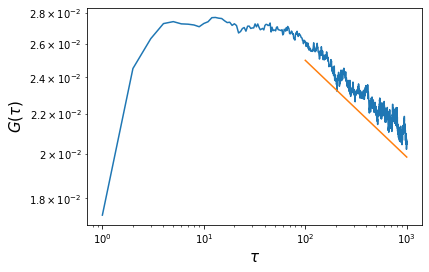

In [21]:
#plt.plot(Response)
t = np.arange(1,1001,1)
plt.plot(t,G[:1000])
plt.plot([100,1000],[0.025,0.025*10**-0.1])
plt.ylabel(r"$G(\tau)$",fontsize=15)
plt.xlabel(r"$\tau$",fontsize=15)
plt.yscale("log")
plt.xscale("log")
#plt.savefig("LO_size.png")
plt.savefig("../../../docs/CodeExample/PriceImpact/PropagatorModel_Direct.png")